In [27]:
import os
import random
import numpy as np
import time

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [28]:
gestures = set()

In [29]:
data_filenames = []

for subject_dir in os.listdir(f'xml_logs'):
    if 'pilot' not in subject_dir and 'README' not in subject_dir:
        for velo_dir in os.listdir(f'xml_logs/{subject_dir}'):
            for filename in os.listdir(f'xml_logs/{subject_dir}/{velo_dir}'):
                if 'ipynb' not in filename:
                    gestures.add(filename[:-6])
                    path = os.path.normpath(f'xml_logs/{subject_dir}/{velo_dir}/{filename}')
                    data_filenames.append(path)


In [30]:
random.shuffle(data_filenames)
test_filenames = []
train_filenames = []
for gesture in gestures:
    gest_filenames = [filename for filename in data_filenames if gesture == filename.split('/')[3][:-6]]
    test_filenames.extend(gest_filenames[:10])
    train_filenames.extend(gest_filenames[10:])


In [31]:
for gesture in gestures:
    count = sum(gesture in s for s in test_filenames)
    print(f'{gesture}: {count}')

triangle: 10
left_sq_bracket: 10
question_mark: 10
rectangle: 10
check: 10
left_curly_brace: 10
v: 10
right_sq_bracket: 10
x: 160
right_curly_brace: 10
circle: 10
arrow: 10
pigtail: 10
delete_mark: 10
star: 10
caret: 10


In [32]:
data_test = []
for filename in test_filenames:
    root = ET.parse(filename).getroot()
    label = filename.split('/')[3][:-6]
    points = []
    for point in root:
        x = point.attrib['X']
        y = point.attrib['Y']
        points.append([x, y])
    points = np.array(points, dtype=float)
    scaler = StandardScaler()
    points = scaler.fit_transform(points)
    resampled = resample(points, NUM_POINTS)
    data_test.append((label, resampled))

In [33]:
data_train = []
for filename in train_filenames:
    root = ET.parse(filename).getroot()
    label = filename.split('/')[3][:-6]
    points = []
    for point in root:
        x = point.attrib['X']
        y = point.attrib['Y']
        points.append([x, y])
    points = np.array(points, dtype=float)
    scaler = StandardScaler()
    points = scaler.fit_transform(points)
    resampled = resample(points, NUM_POINTS)
    data_train.append((label, resampled))

In [34]:
labels_test = [sample[0] for sample in data_test]
labels_train = [sample[0] for sample in data_train]

encoder_test = LabelEncoder()
labels_test_encoded = encoder_test.fit_transform(labels_test)
y_test = to_categorical(labels_test_encoded)

encoder_train = LabelEncoder()
labels_train_encoded = encoder_train.fit_transform(labels_train)
y_train = to_categorical(labels_train_encoded)

sequences_test = [sample[1] for sample in data_test]
sequences_train = [sample[1] for sample in data_train]

X_test = np.array(sequences_test)
X_train = np.array(sequences_train)

Define functions for building and fitting the model as well as displaying results.

In [35]:
def build_model(lstm_units):
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(lstm_units, input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(gestures), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [36]:
def fit_model(model):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    start = time.time()
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[reduce_lr, stop_early],
    )
    duartion = time.time() - start
    return history, duartion

In [37]:
def display_summary(model):
    model.summary()

In [38]:
def display_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [39]:
def predict_and_display_conf_matrix(model):
    start = time.time()
    y_predictions = model.predict(X_test)
    duration = time.time() - start

    y_predictions = np.argmax(y_predictions, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))
    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_test)).plot(ax=plt.gca())
    plt.xticks(rotation=90, ha='center')
    pass
    return duration

In [40]:
y_test.shape, y_train.shape

((160, 16), (5120, 16))

## Condition 1 - 128 Units in LSTM Layer

Epoch 1/20
160/160 [==============================] - 9s 46ms/step - loss: 0.8378 - accuracy: 0.7648 - val_loss: 0.1511 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 6s 40ms/step - loss: 0.1206 - accuracy: 0.9658 - val_loss: 0.0665 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 7s 43ms/step - loss: 0.0745 - accuracy: 0.9820 - val_loss: 0.0833 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 7s 41ms/step - loss: 0.0511 - accuracy: 0.9871 - val_loss: 0.0812 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 7s 46ms/step - loss: 0.0286 - accuracy: 0.9928 - val_loss: 0.0393 - val_accuracy: 0.9812 - lr: 2.0000e-04
Epoch 6/20
160/160 [==============================] - 7s 42ms/step - loss: 0.0166 - accuracy: 0.9967 - val_loss: 0.0339 - val_accuracy: 0.9875 - lr: 2.0000e-04
Epoch 7/20
160/160 [==============================] - 6s

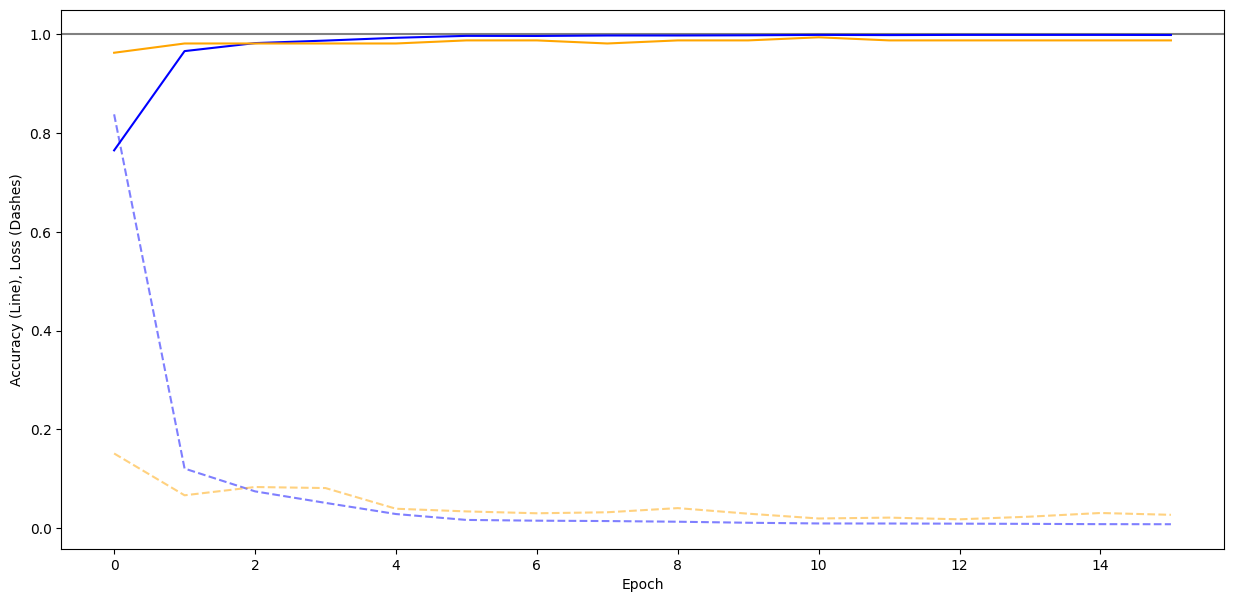

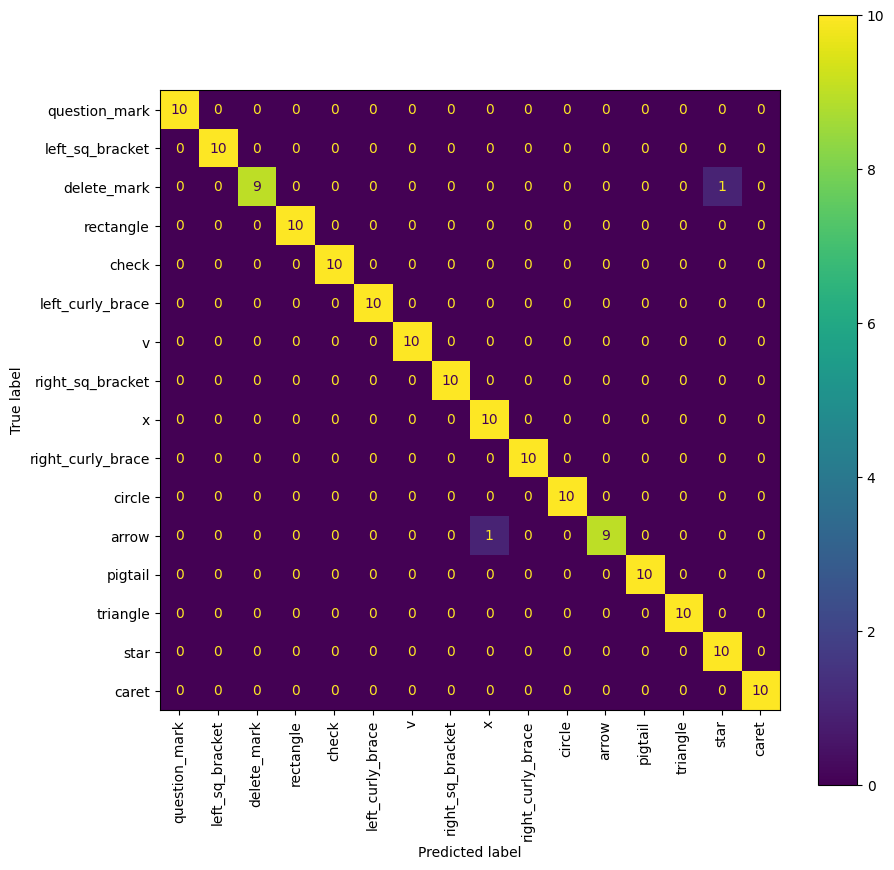

In [41]:
UNITS_LSTM = 128

model_cond1 = build_model(UNITS_LSTM)
history_cond1, duration_train_cond1 = fit_model(model_cond1)
display_summary(model_cond1)
display_results(history_cond1)
duration_predict_cond1 = predict_and_display_conf_matrix(model_cond1)
acc_cond1 = history_cond1.history['val_accuracy']

## Condition 2 - 64 Units in LSTM Layer

Epoch 1/20
160/160 [==============================] - 5s 20ms/step - loss: 1.2810 - accuracy: 0.6408 - val_loss: 0.4554 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 3s 18ms/step - loss: 0.1929 - accuracy: 0.9475 - val_loss: 0.1268 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 3s 19ms/step - loss: 0.0892 - accuracy: 0.9773 - val_loss: 0.0831 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 3s 19ms/step - loss: 0.0675 - accuracy: 0.9840 - val_loss: 0.0387 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 3s 19ms/step - loss: 0.0593 - accuracy: 0.9844 - val_loss: 0.0824 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/20
160/160 [==============================] - 3s 19ms/step - loss: 0.0453 - accuracy: 0.9885 - val_loss: 0.1113 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 7/20
160/160 [==============================] - 3s 17ms/st

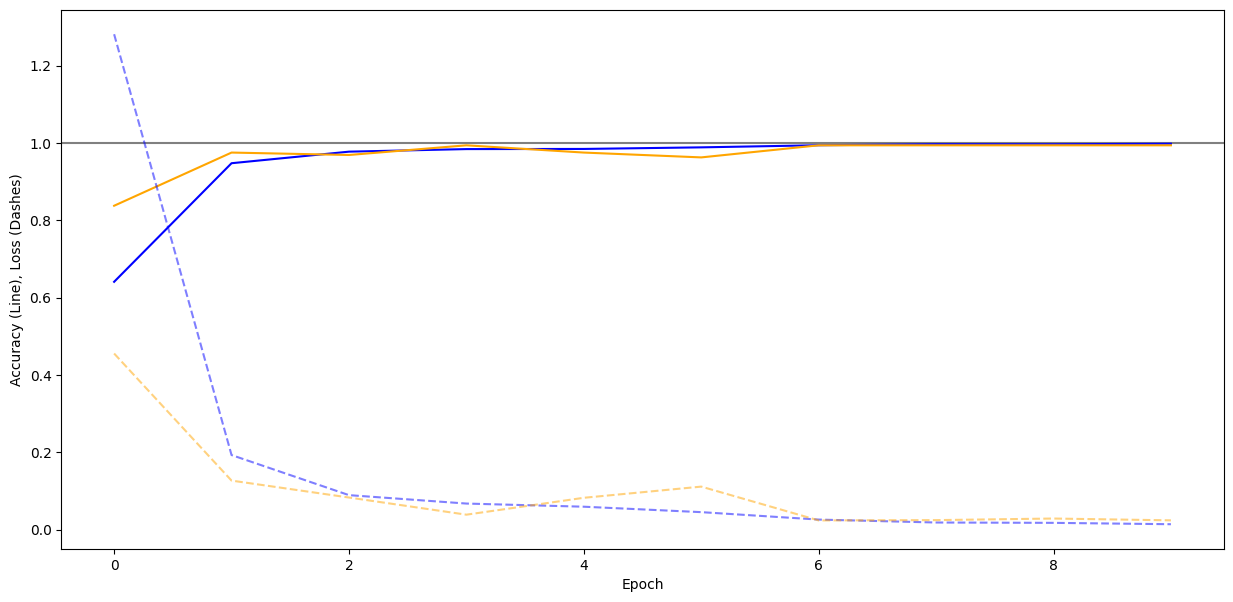

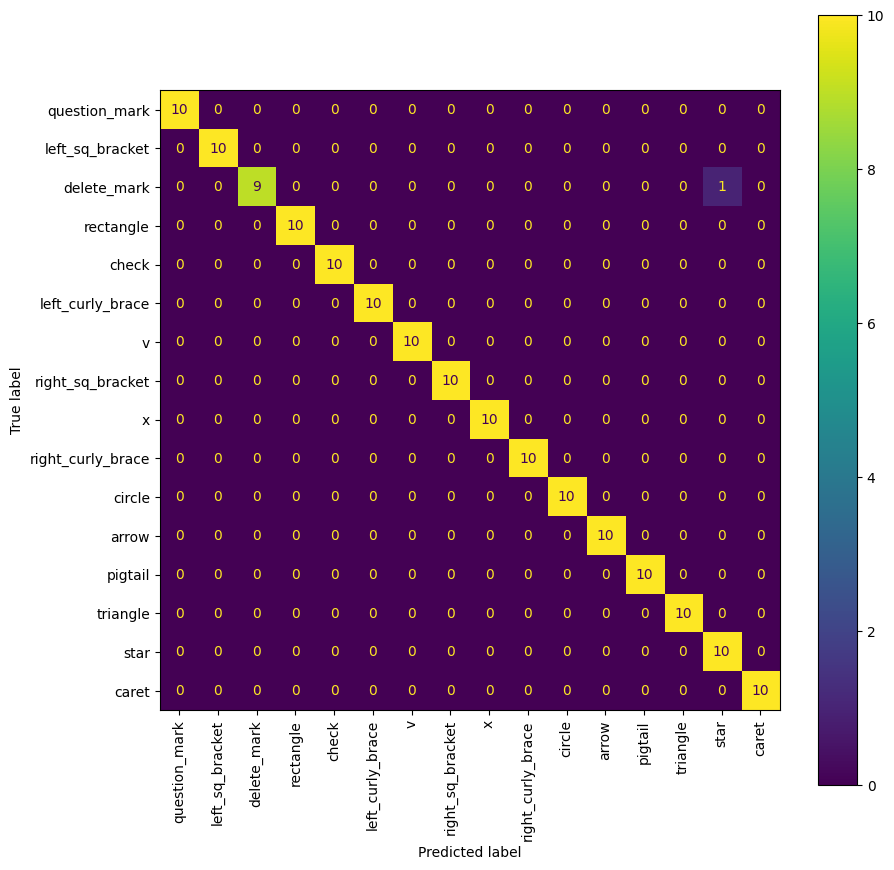

In [42]:
UNITS_LSTM = 64

model_cond2 = build_model(UNITS_LSTM)
history_cond2, duration_train_cond2 = fit_model(model_cond2)
display_summary(model_cond2)
display_results(history_cond2)
duration_predict_cond2 = predict_and_display_conf_matrix(model_cond2)
acc_cond2 = history_cond2.history['val_accuracy']

## Condition 3 - 32 Units in LSTM Layer

Epoch 1/20
160/160 [==============================] - 5s 18ms/step - loss: 1.7496 - accuracy: 0.5123 - val_loss: 0.6413 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 2s 14ms/step - loss: 0.3590 - accuracy: 0.9041 - val_loss: 0.2423 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 2s 14ms/step - loss: 0.1777 - accuracy: 0.9480 - val_loss: 0.1583 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 2s 14ms/step - loss: 0.0980 - accuracy: 0.9773 - val_loss: 0.0962 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 2s 14ms/step - loss: 0.0604 - accuracy: 0.9873 - val_loss: 0.0450 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/20
160/160 [==============================] - 2s 14ms/step - loss: 0.0514 - accuracy: 0.9877 - val_loss: 0.0661 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 7/20
160/160 [==============================] - 2s 14ms/st

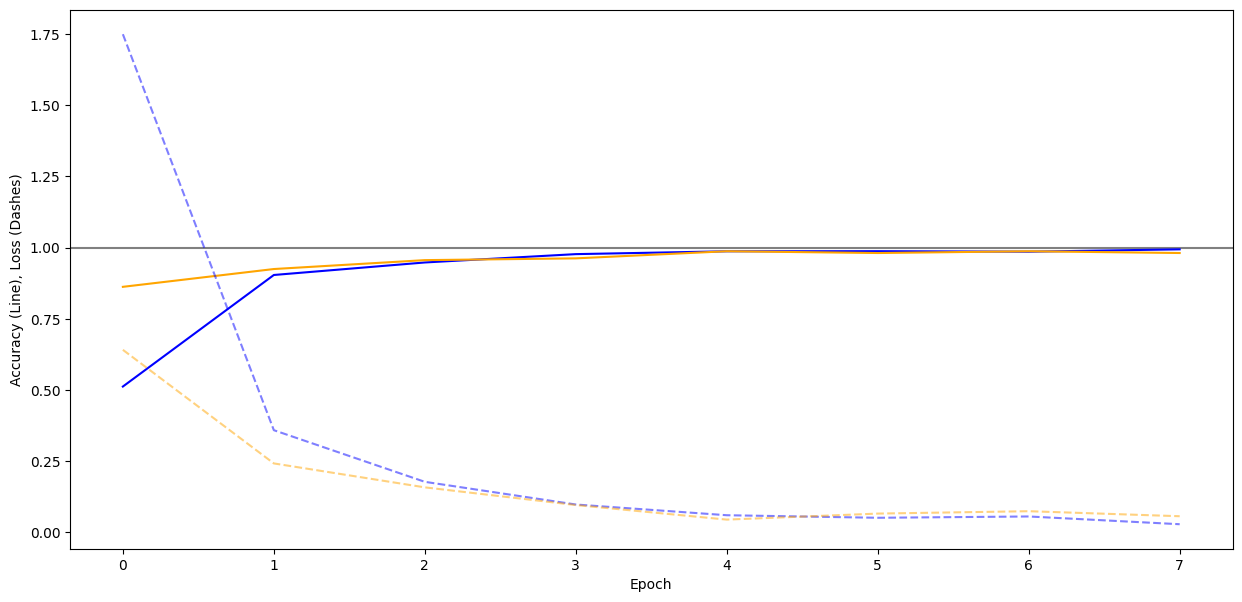

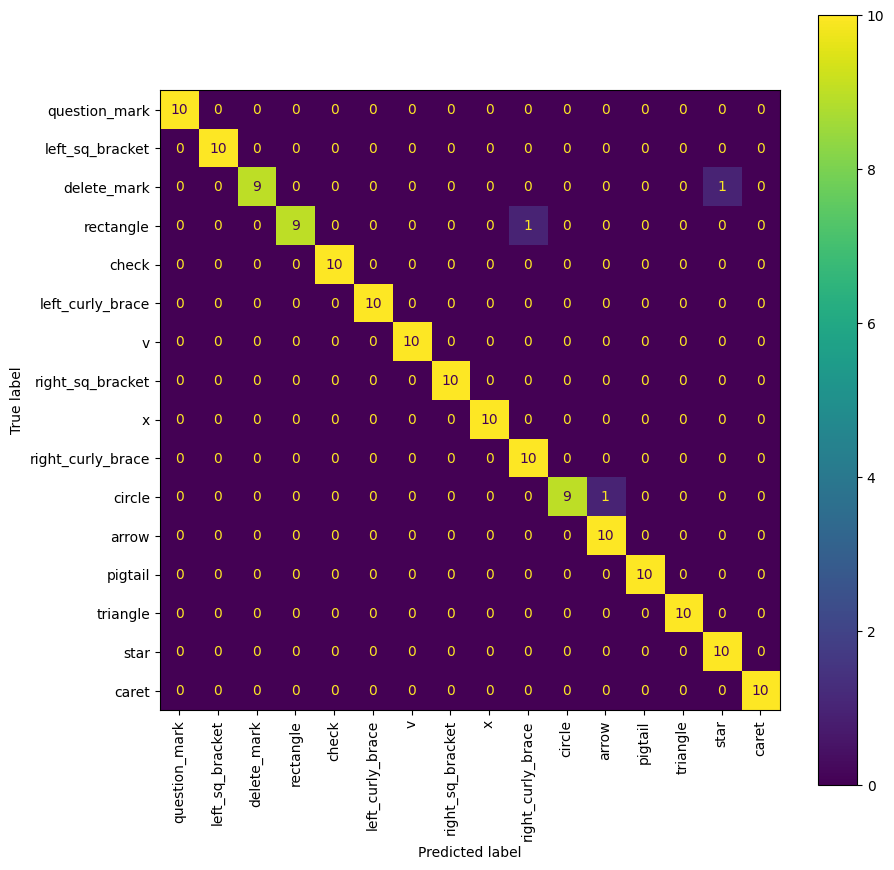

In [43]:
UNITS_LSTM = 32

model_cond3 = build_model(UNITS_LSTM)
history_cond3, duration_train_cond3 = fit_model(model_cond3)
display_summary(model_cond3)
display_results(history_cond3)
duration_predict_cond3 = predict_and_display_conf_matrix(model_cond3)
acc_cond3 = history_cond3.history['val_accuracy']

## Condition 4 - 16 Units in LSTM Layer

Epoch 1/20
160/160 [==============================] - 4s 16ms/step - loss: 2.0915 - accuracy: 0.3732 - val_loss: 1.3155 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 2s 12ms/step - loss: 0.8501 - accuracy: 0.7586 - val_loss: 0.6424 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 2s 13ms/step - loss: 0.4574 - accuracy: 0.8598 - val_loss: 0.4293 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 2s 13ms/step - loss: 0.2860 - accuracy: 0.9225 - val_loss: 0.3061 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 2s 12ms/step - loss: 0.1814 - accuracy: 0.9566 - val_loss: 0.2152 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 6/20
160/160 [==============================] - 2s 12ms/step - loss: 0.1221 - accuracy: 0.9705 - val_loss: 0.2100 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 7/20
160/160 [==============================] - 2s 13ms/st

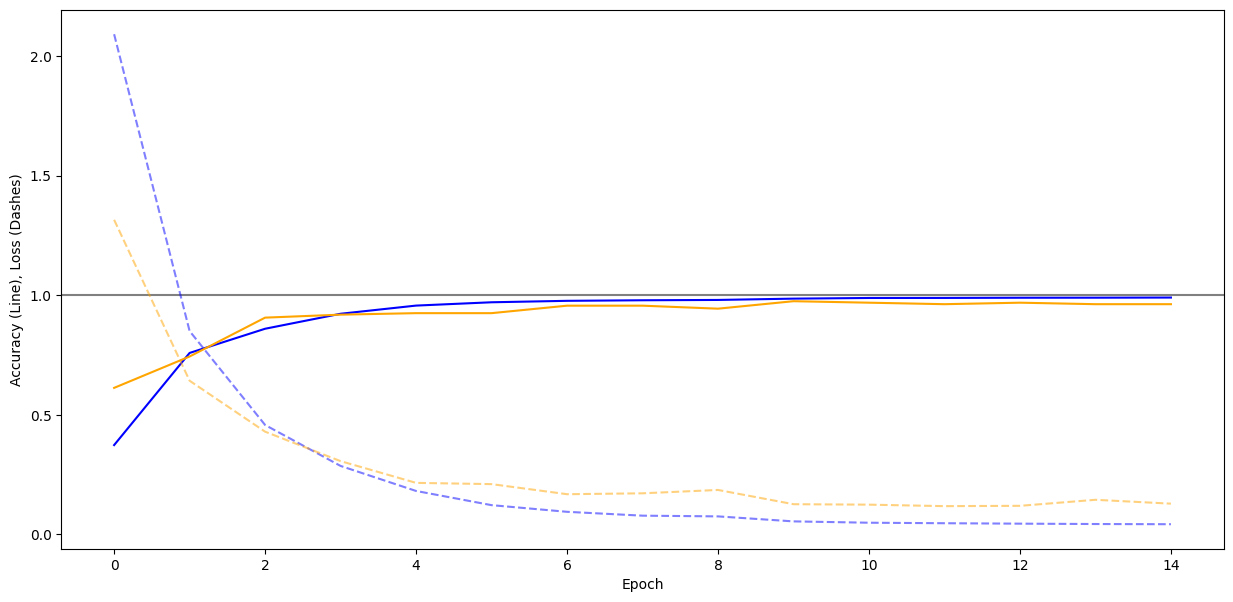

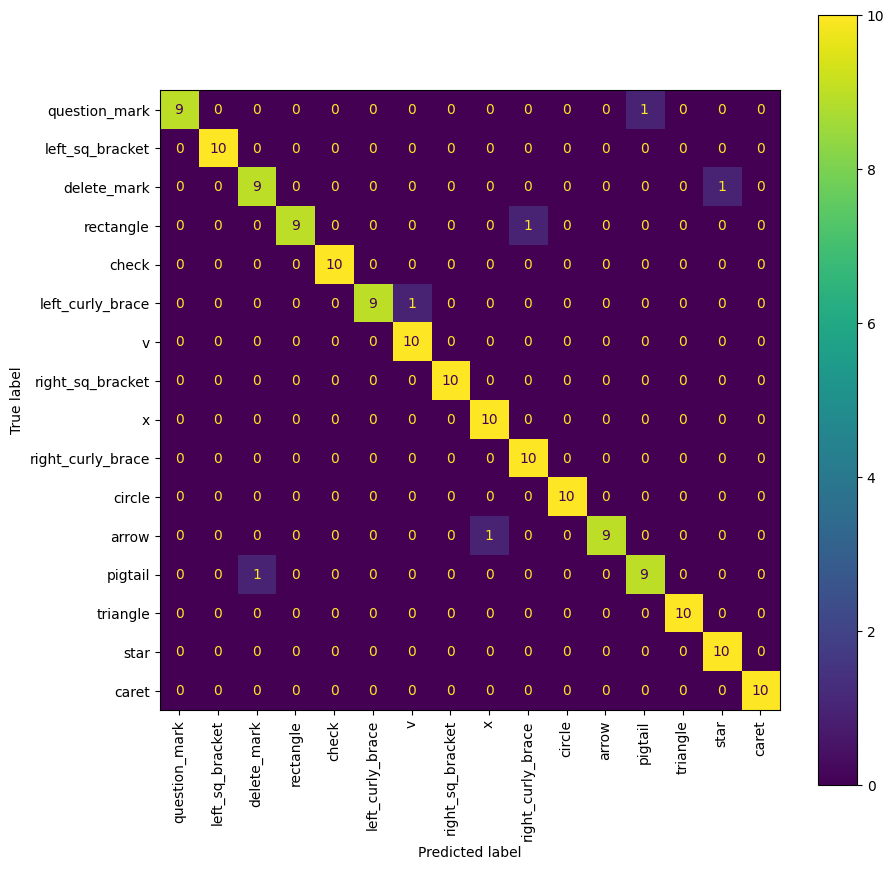

In [44]:
UNITS_LSTM = 16

model_cond4 = build_model(UNITS_LSTM)
history_cond4, duration_train_cond4 = fit_model(model_cond4)
display_summary(model_cond4)
display_results(history_cond4)
duration_predict_cond4 = predict_and_display_conf_matrix(model_cond4)
acc_cond4 = history_cond4.history['val_accuracy']

## Condition 5 - $1 Gesture Recognizer

In [45]:
from recognizer import OneDollarRecognizer

recognizer = OneDollarRecognizer(gestures)

In [46]:
start_predict_dollar = time.time()
y_predictions = []
for i, points in enumerate(X_test):
    points_input = recognizer.rotate(points)  # just rotate, everything else is already done for X_test
    gesture, score = recognizer.recognize(points_input)
    y_predictions.append(gesture)

duration_predict_dollar = time.time() - start_predict_dollar

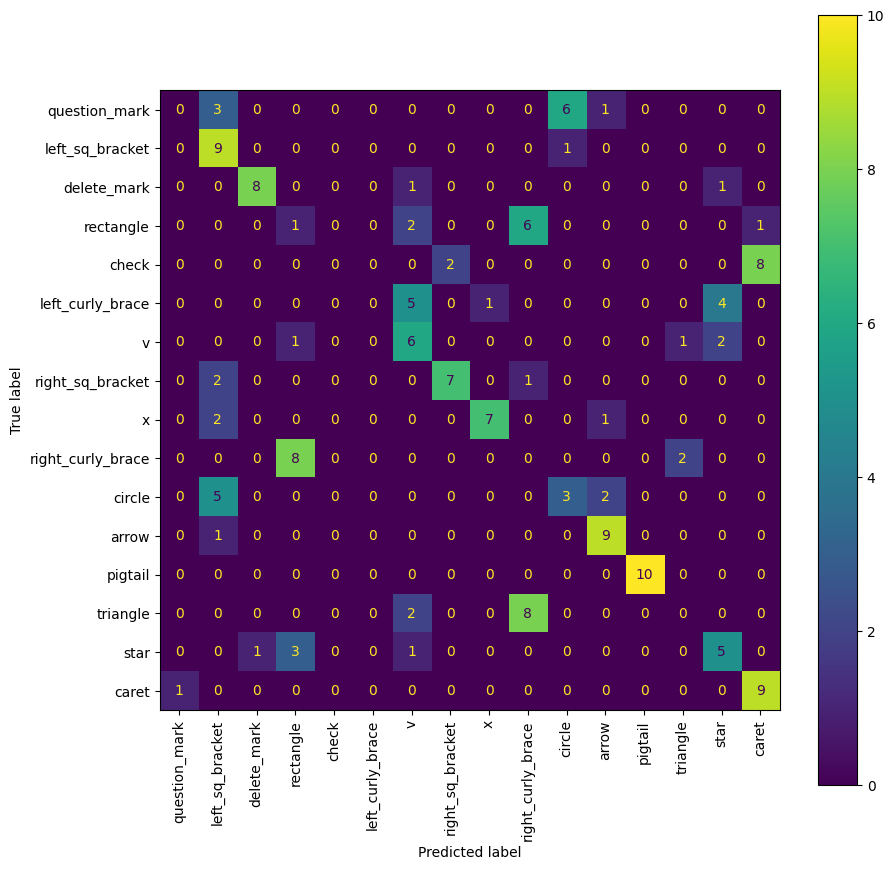

In [47]:
y_test_labels = np.argmax(y_test, axis=1)
y_test_labels = encoder_test.inverse_transform(y_test_labels)
conf_matrix = confusion_matrix(y_test_labels, y_predictions)
acc_dollar = sum(1 for predict, test in zip(y_predictions, y_test_labels) if predict == test) / len(y_predictions)

fig = plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_test)).plot(ax=plt.gca())
plt.xticks(rotation=90, ha='center')
pass

## Comparing the Conditions

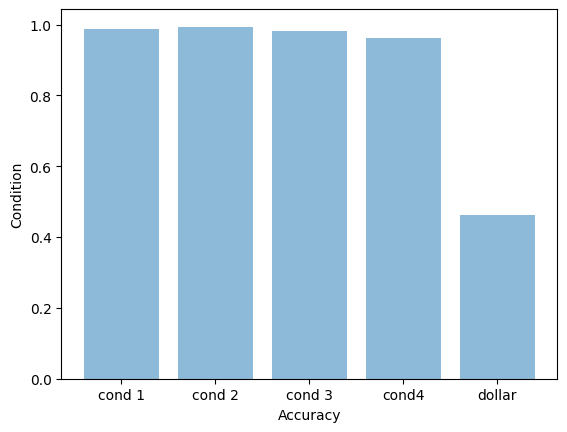

In [53]:
objects = ('cond 1', 'cond 2', 'cond 3', 'cond4', 'dollar')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [acc_cond1[-1], acc_cond2[-1], acc_cond3[-1], acc_cond4[-1], acc_dollar], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Condition')
plt.xlabel('Accuracy')

plt.show()

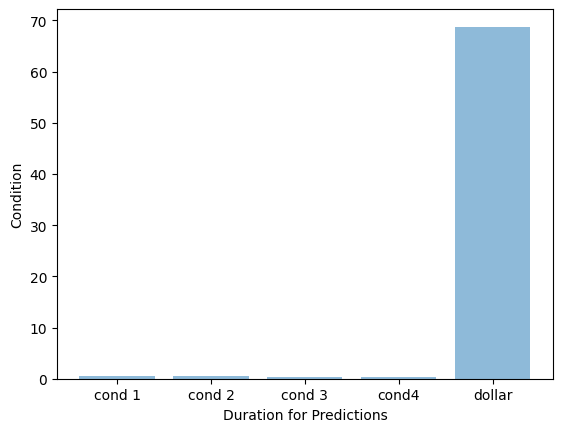

In [49]:
objects = ('cond 1', 'cond 2', 'cond 3', 'cond4', 'dollar')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [duration_predict_cond1, duration_predict_cond2, duration_predict_cond3, duration_predict_cond4, duration_predict_dollar], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Condition')
plt.xlabel('Duration for Predictions')

plt.show()

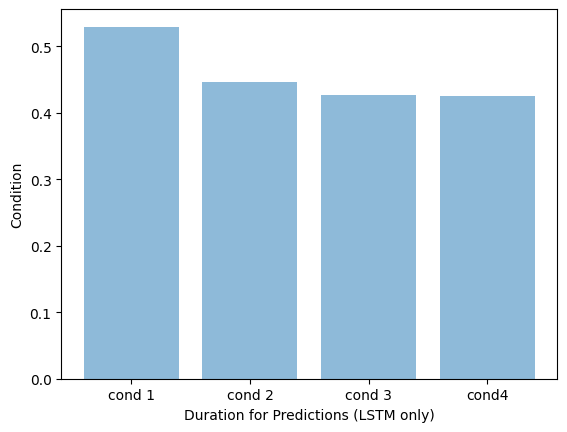

In [54]:
objects = ('cond 1', 'cond 2', 'cond 3', 'cond4')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [duration_predict_cond1, duration_predict_cond2, duration_predict_cond3, duration_predict_cond4], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Condition')
plt.xlabel('Duration for Predictions (LSTM only)')

plt.show()

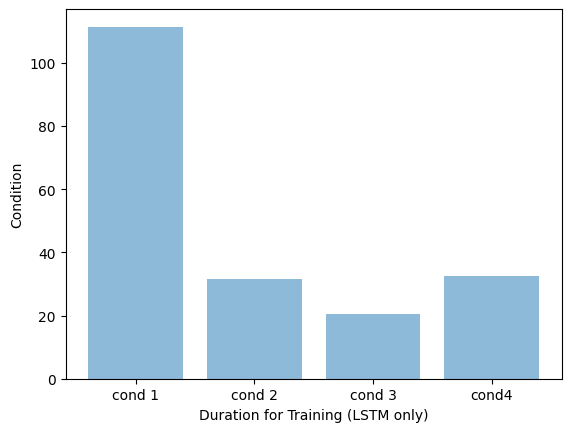

In [50]:
objects = ('cond 1', 'cond 2', 'cond 3', 'cond4')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [duration_train_cond1, duration_train_cond2, duration_train_cond3, duration_train_cond4], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Condition')
plt.xlabel('Duration for Training (LSTM only)')

plt.show()